In [ ]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

In [1]:
!pip install gdown

# create directory for storing data
!mkdir -p images

# download zip file with training set
!gdown https://drive.google.com/uc?id=1rTf4DJI2PoM-hgSSSzvpOQcQhui3qh-y && unzip -qq train.zip -d images
!rm train.zip

# download zip with valid set
!gdown https://drive.google.com/uc?id=1yB-KN--FjiWZrA6XwxaSvtXhtcbk80dQ && unzip -qq valid.zip -d images
!rm valid.zip

# download zip with utils
!gdown https://drive.google.com/uc?id=1LbwczJVpDLsMGS7yGMP7z1GCAMg4NCsS && unzip -qq utils.zip
!rm utils.zip

# change dir to the one with data 
!cd /content

/bin/sh: gdown: command not found


# Model V3

Model based on the auto-encoder presented in the *Advanced Deep Learning with Keras* book with the code available here: https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter3-autoencoders/colorization-autoencoder-cifar10-3.4.1.py

## Setup

First, we install the required libraries.

In [23]:
#!pip install -r requirements.txt --quiet

Then, we import all the libraries we will use for the project.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# plotting
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [5]:
import numpy as np

import torch 
import torch.nn as nn

from torchvision import transforms

import os, time
from datetime import datetime 

from skimage.color import rgb2lab, lab2rgb
from skimage.io import imshow

from utils import get_random_file
from image_utils import preview_dataloader_lab, combine_channels
from dataloaders import ColorizationImageFolder
from dl_utils import *
from train import *
from models import *

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}!')
custom_set_seed(42) # for reproducibility

Running on cpu!


**Define parameters**

In [7]:
# data loaders
BATCH_SIZE = 32 # number of samples to load per batch
IMG_SIZE = 224

# model
save_images = True
epochs = 10
print_every = 1
save_every = 5
lab_version = 1

# make output folders
OUTPUT_PATH = 'v3_outputs'
CHECKPOINTS_PATH = 'v3_checkpoints'

os.makedirs(f'{OUTPUT_PATH}/color', exist_ok=True)
os.makedirs(f'{OUTPUT_PATH}/gray', exist_ok=True)
os.makedirs(f'{CHECKPOINTS_PATH}', exist_ok=True)

## DataLoaders

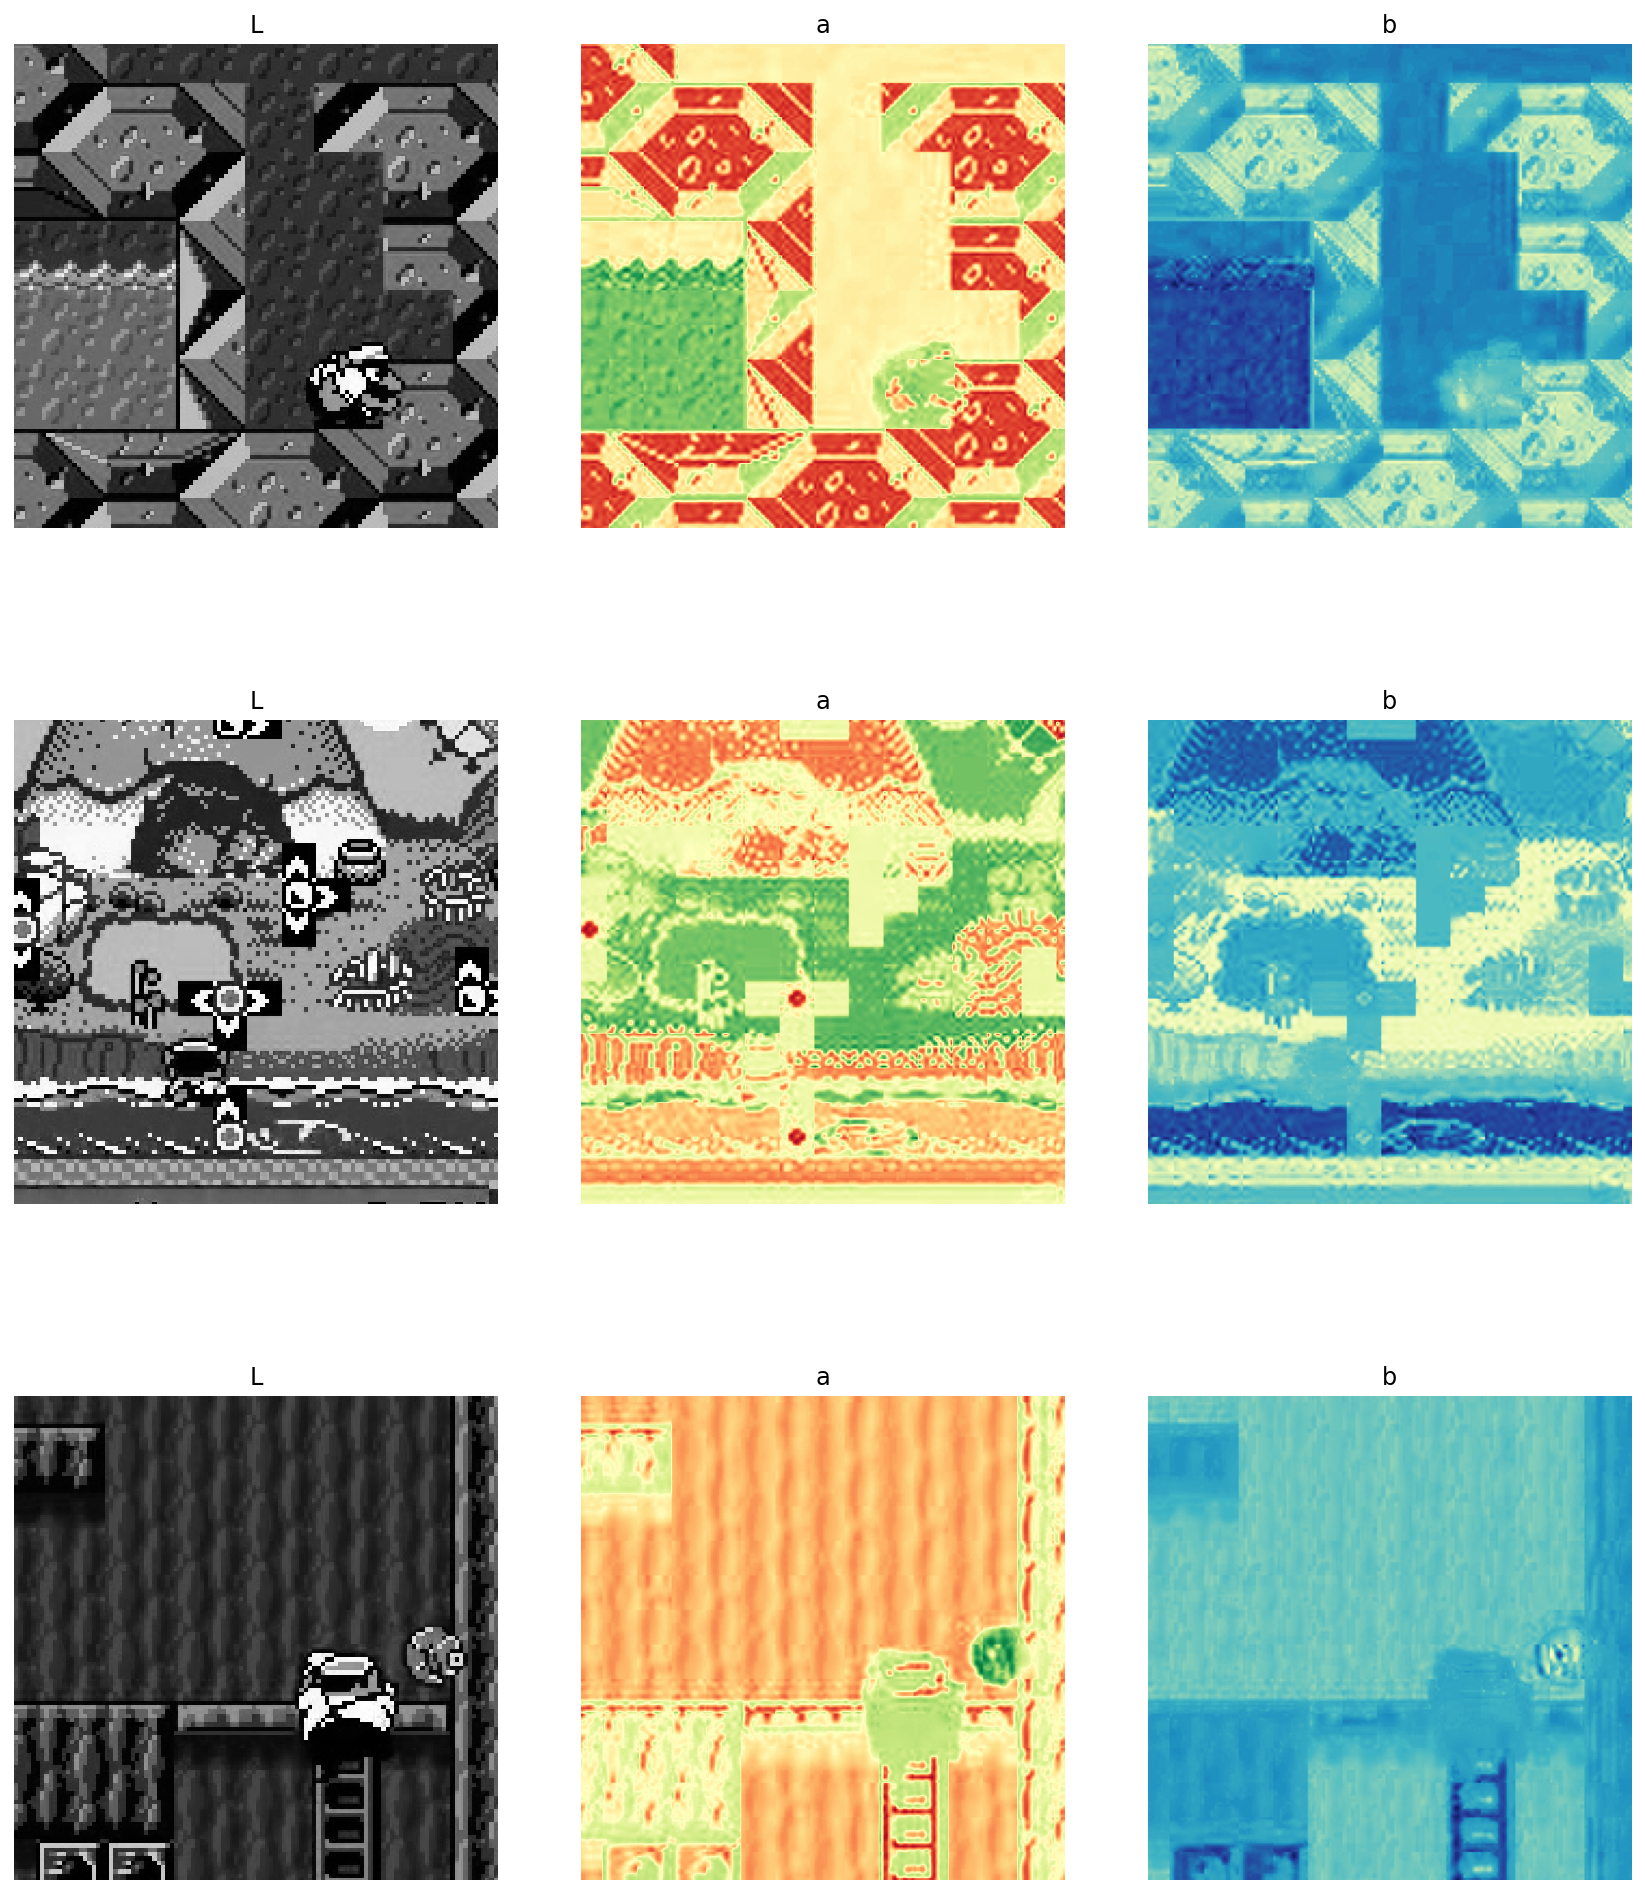

In [8]:
# define transformations
train_transforms = transforms.Compose([
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5)
])

valid_transforms = transforms.Compose([
    transforms.CenterCrop((IMG_SIZE, IMG_SIZE))
])

# image folders
train_folder = ColorizationImageFolder(root='images/train', 
                                       lab_version=lab_version, 
                                       transform=train_transforms)
valid_folder = ColorizationImageFolder(root='images/valid', 
                                       lab_version=lab_version, 
                                       transform=valid_transforms)

# image loaders 
train_loader = torch.utils.data.DataLoader(train_folder, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_folder, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=False)

# preview the images
img_gray, img_ab = preview_dataloader_lab(train_loader)

## Model

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
        
class Unflatten(nn.Module):
    def __init__(self, channels, img_size):
        self.channels = channels
        self.img_size = img_size
        
    def forward(self, x):
        return x.view(-1, self.channels, self.img_size, self.img_size)

In [10]:
class ColorCNN_v3(nn.Module):
    def __init__(self, lab_version, latent_vector=4):
        super(ColorCNN_v3, self).__init__()

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        if lab_version == 1:
            self.final = nn.Tanh()
        elif lab_version == 2:
            self.final = nn.Sigmoid()
            
        self.flatten = Flatten()
        
        # encoder 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=2, padding=1, bias=True)
        
        self.linear_enc = nn.Linear(14 * 14 * 256, latent_vector)
        
        #decoder
        self.linear_dec = nn.Linear(latent_vector, 14 * 14 * 256)
        
        self.convt1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.convt2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.convt3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.convt4 = nn.ConvTranspose2d(in_channels=64, out_channels=2, kernel_size=(3,3), stride=2, padding=1, bias=True)
            
    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
#        x = self.linear_enc(x)
#         x = self.linear_dec(x)
#         x = x.view(-1, 256, 14, 14)
#         x = self.relu(self.convt1(x))
#         x = self.relu(self.convt2(x))
#         x = self.relu(self.convt3(x))
#         x = self.final(self.convt4(x))
                
        return x


In [11]:
model = ColorCNN_v3(lab_version=lab_version).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [12]:
y = model(img_gray)
y.shape

torch.Size([32, 50176])

In [14]:
lin = nn.Linear(14 * 14 * 256, 32)

In [ ]:
lin(y[0]).shape

In [13]:
14 * 14 * 256

50176

In [ ]:
Flatten()(y).view(-1, 256, 14, 14).shape

In [ ]:
x = model(img_gray)
x.shape

In [ ]:
model

In [ ]:
# set objects for storing metrics
best_loss = 1e10
train_losses = []
valid_losses = []
time_meter = AverageMeter()

# Train model
for epoch in range(0, epochs):
    
    start_time = time.time()
    
    # training
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # validation
    with torch.no_grad():
        model, valid_loss = validate(valid_loader, model, criterion, save_images, 
                                     f'{OUTPUT_PATH}/gray/', 
                                     f'{OUTPUT_PATH}/color/', 
                                     device, 
                                     epoch, 
                                     lab_version)
        valid_losses.append(valid_loss)
        
    checkpoint = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_losses': train_losses,
            'valid_losses': valid_losses
    }
    
    if epoch % save_every == (save_every - 1):
        save_checkpoint(checkpoint, filename=f'checkpoint_epoch_{epoch}.pth.tar', path=CHECKPOINTS_PATH)
    
    # Save checkpoint and replace old best model if current model is better
    if valid_loss < best_loss:
        best_loss = valid_loss
        save_checkpoint(checkpoint, is_best=True, path=CHECKPOINTS_PATH)
        
    end_time = time.time()
    epoch_time = end_time - start_time
    time_meter.update(epoch_time)
        
    if epoch % print_every == (print_every - 1):
        print(f'{datetime.now().time().replace(microsecond=0)} --- '
              f'Epoch: {epoch}\t'
              f'Train loss: {train_loss:.4f}\t'
              f'Valid loss: {valid_loss:.4f}\t'
              f'Epoch time: {epoch_time:.2f} (avg. {time_meter.avg:.2f})')
        
plot_losses(train_losses[1:], valid_losses[1:])

### Manual Evaluation

In [87]:
show_model_results(model, 
                   model_name='Model V0', 
                   lab_version=1, 
                   path=get_random_file('images/train/wario/', 'jpg'), 
                   img_size=IMG_SIZE, 
                   device=device)

## Download checkpoints from Colab

In [ ]:
!zip checkpoints.zip v0_checkpoints

In [ ]:
# save files if in Google Colab
files.download('checkpoints.zip')